# WORKER2 - Generate MultiDepth    MAXGRAD

In [1]:
from pathlib import Path
from tqdm import trange

import torch
import torch.nn.functional as F

import taichi as ti

from differender.volume_raycaster import Raycaster, Mode
from differender.utils import get_rand_pos, in_circles, get_tf

from torchvtk.datasets import TorchDataset
from torchvtk.utils import TFGenerator, tex_from_pts, make_4d
from torchvtk.rendering import show_tf, plot_tf, plot_comp_render_tf

import matplotlib.pyplot as plt

[Taichi] version 0.8.5, llvm 10.0.0, commit 45c6ad48, linux, python 3.7.11
[I 03/09/22 13:16:11.017 925] [shell.py:_shell_pop_print@34] Graphical python shell detected, using wrapped sys.stdout
[TaiGLSL] version 0.0.11


In [26]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'wysiwyp'],
                                        ['depth1', 'depth2', 'depth3'],
                                        ['alpha1', 'alpha2', 'alpha3'],
                                        ['sorted1','sorted2','sorted3'],
                                        ['diff1','diff2','diff3']], figsize=(15,25))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['rgb'].set_axis_off()
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['alpha'].set_axis_off()
    axs['wysiwyp'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    axs['wysiwyp'].set_axis_off()    
    
    axs['depth1'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['depth1'].set_title('Interval 1')
    axs['depth1'].set_axis_off()
    axs['depth2'].imshow(im.squeeze()[[5]].permute(1,2,0).cpu().numpy())
    axs['depth2'].set_title('Interval 2')
    axs['depth2'].set_axis_off()
    axs['depth3'].imshow(im.squeeze()[[6]].permute(1,2,0).cpu().numpy())
    axs['depth3'].set_title('Interval 3')
    axs['depth3'].set_axis_off()
    axs['alpha1'].imshow(im.squeeze()[[7]].permute(1,2,0).cpu().numpy())
    axs['alpha1'].set_title('Alpha at I1')
    axs['alpha1'].set_axis_off()
    axs['alpha2'].imshow(im.squeeze()[[8]].permute(1,2,0).cpu().numpy())
    axs['alpha2'].set_title('Alpha at I2')
    axs['alpha2'].set_axis_off()
    axs['alpha3'].imshow(im.squeeze()[[9]].permute(1,2,0).cpu().numpy())
    axs['alpha3'].set_title('Alpha at I3')
    axs['alpha3'].set_axis_off()

    
    sorted_depth, idx = rgbad[4:7].sort(dim=0)
    axs['sorted1'].imshow(sorted_depth[[0]].permute(1,2,0).cpu().numpy())
    axs['sorted1'].set_title('Sorted Depth 1')
    axs['sorted1'].set_axis_off()
    axs['sorted2'].imshow(sorted_depth[[1]].permute(1,2,0).cpu().numpy())
    axs['sorted2'].set_title('Sorted Depth 2')
    axs['sorted2'].set_axis_off()
    axs['sorted3'].imshow(sorted_depth[[2]].permute(1,2,0).cpu().numpy())
    axs['sorted3'].set_title('Sorted Depth 3')
    axs['sorted3'].set_axis_off()
    
    if 'diff1' in axs:
        diff1 = sorted_depth[1] - sorted_depth[0]
        diff2 = sorted_depth[2] - sorted_depth[1]
        diff3 = sorted_depth[2] - sorted_depth[0]
        axs['diff1'].imshow(diff1[None].permute(1,2,0).cpu().numpy())
        axs['diff1'].set_title('Sorted 2 - 1')
        axs['diff1'].set_axis_off()
        axs['diff2'].imshow(diff2[None].permute(1,2,0).cpu().numpy())
        axs['diff2'].set_title('Sorted 3 - 2')
        axs['diff2'].set_axis_off()
        axs['diff3'].imshow(diff3[None].permute(1,2,0).cpu().numpy())
        axs['diff3'].set_title('Sorted 3 - 1')
        axs['diff3'].set_axis_off()
    
    
    
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True, normalize=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    if normalize:
        hst /= im.numel()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        fig.suptitle(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

In [3]:
N_ITEMS = 100000
W, H = 512, 512
TF_RES = 256
BINS = 51
SR = 16.0 # Sampling rate
MODE = Mode.MaxGradient

out_dir = Path('/mnt/hdd/dome/STDepth_data_multi_mg')
#ds = TorchDataset('/run/media/dome/Data/data/torchvtk/CQ500')
ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
N_VOLUMES = len(ds)

In [4]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': 3,
    'height_range': (0.02, 0.4),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

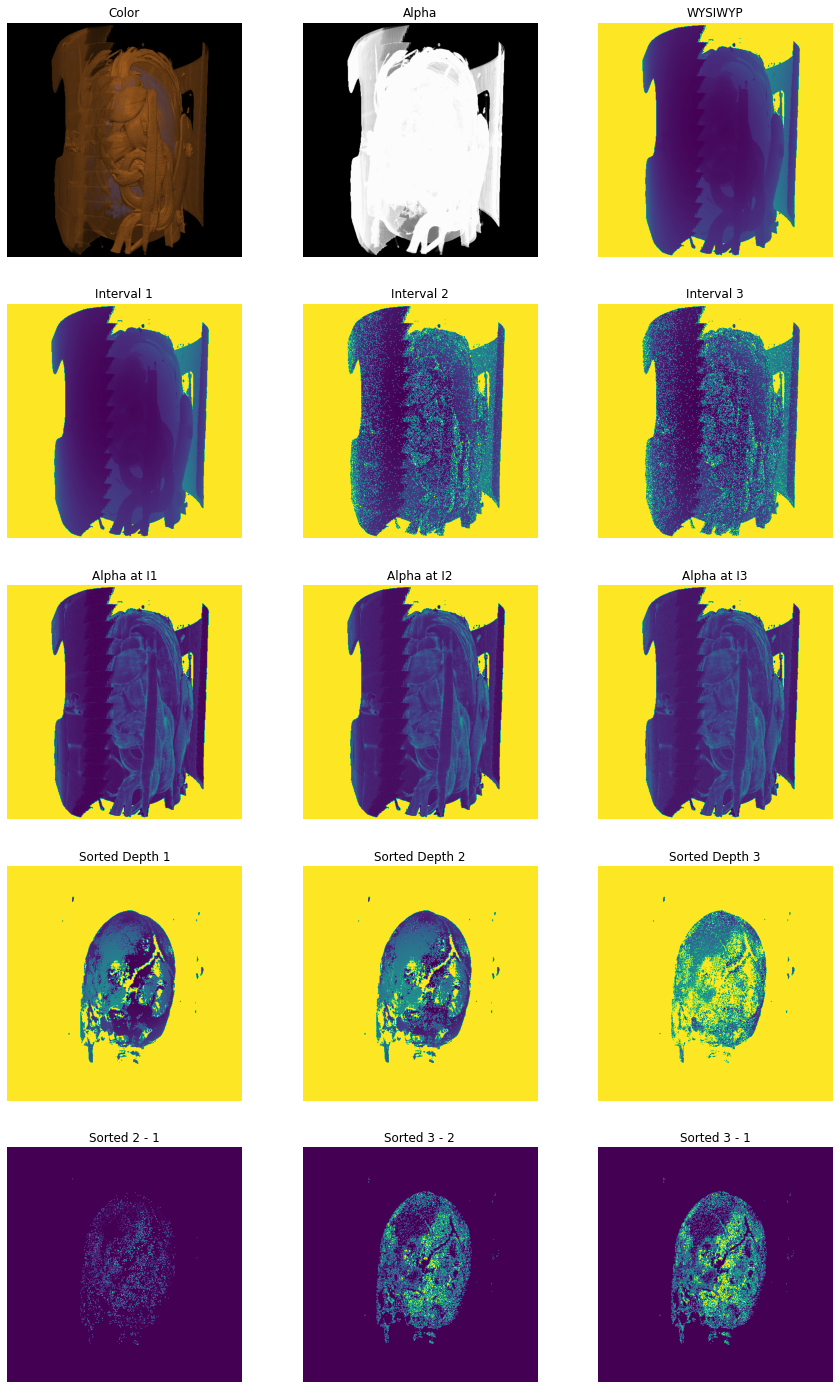

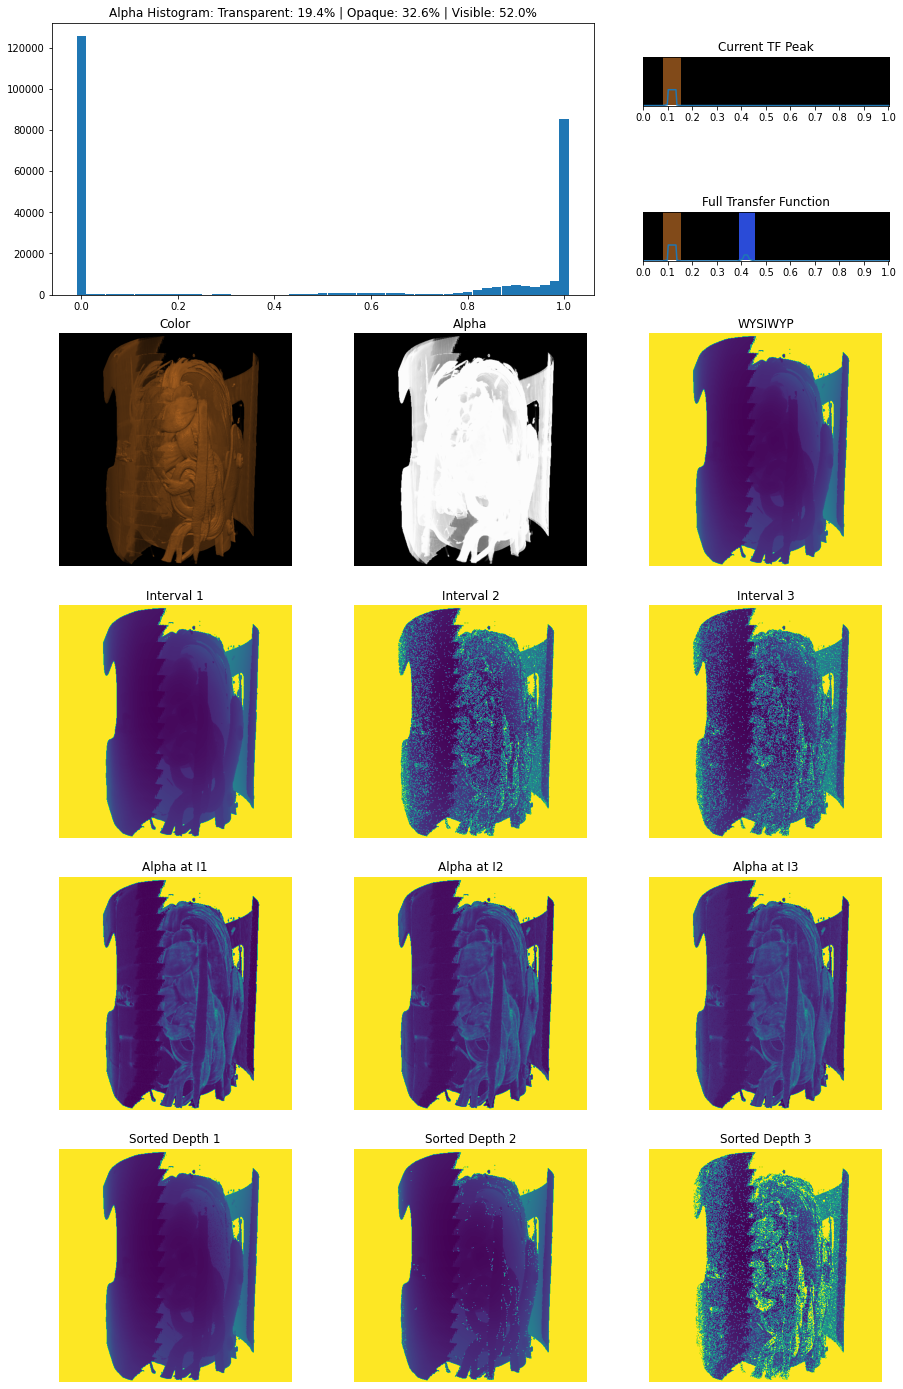

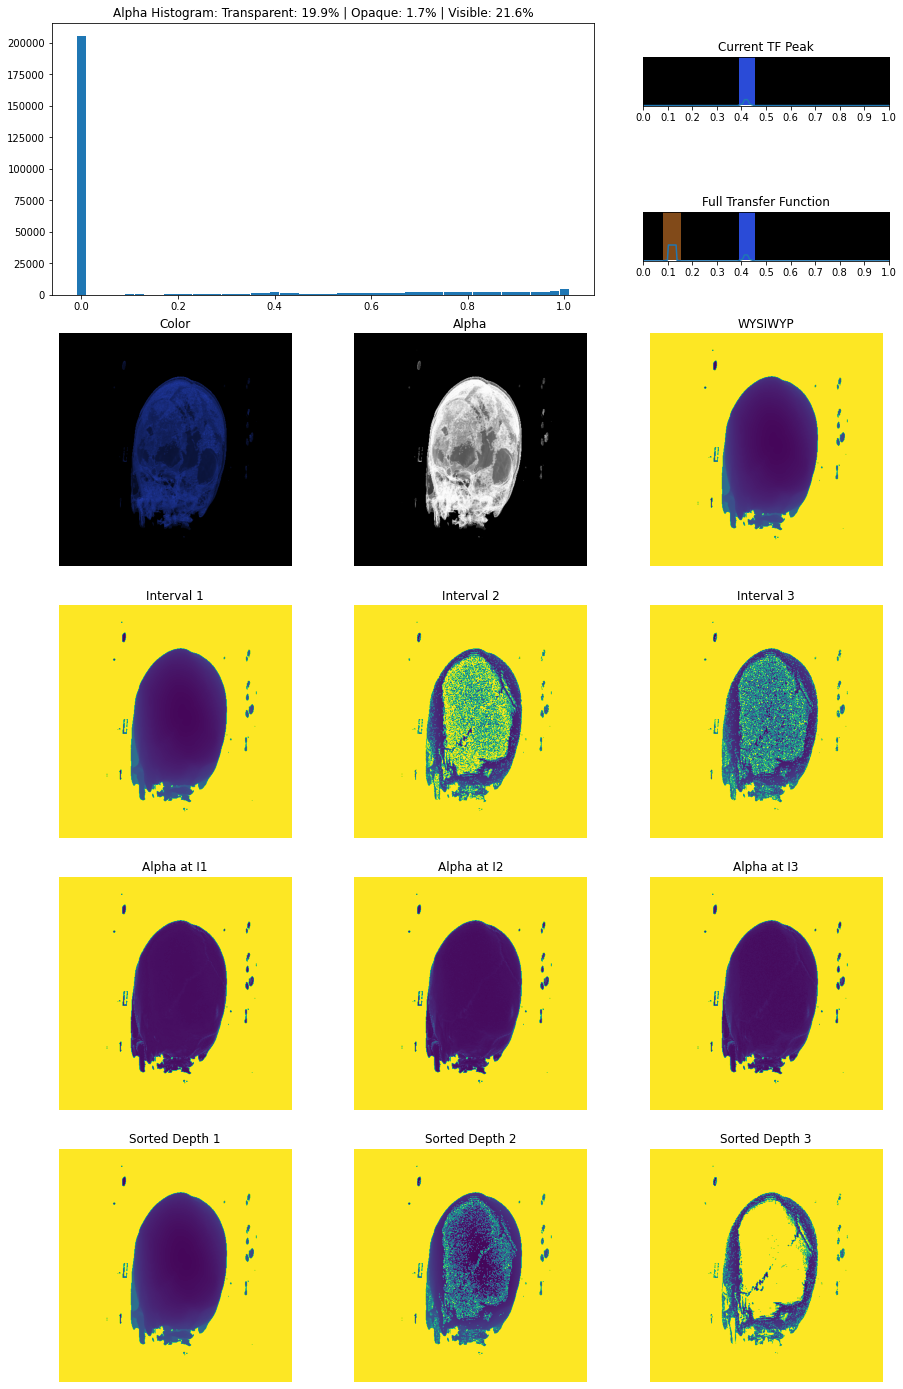

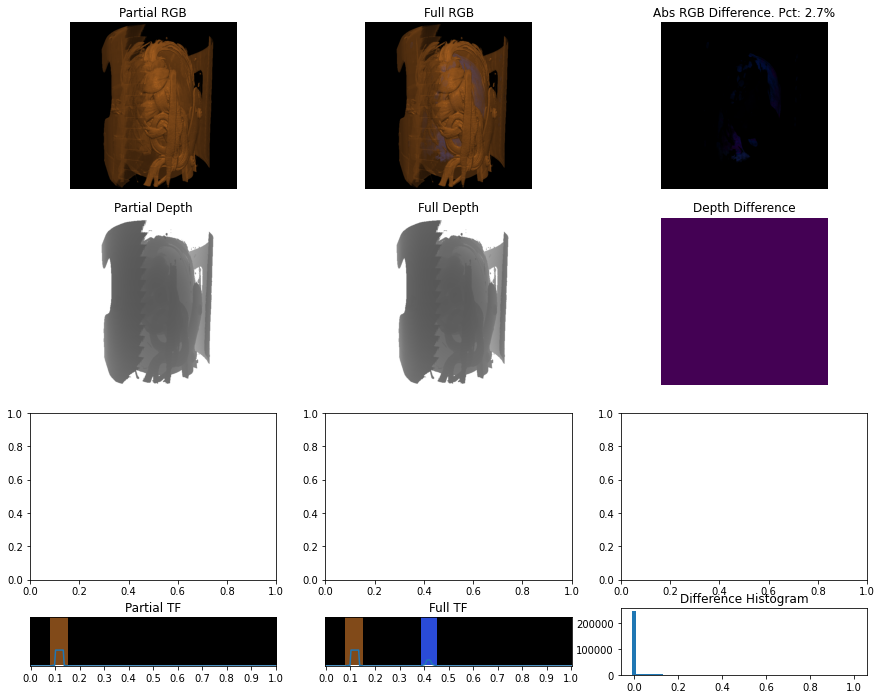

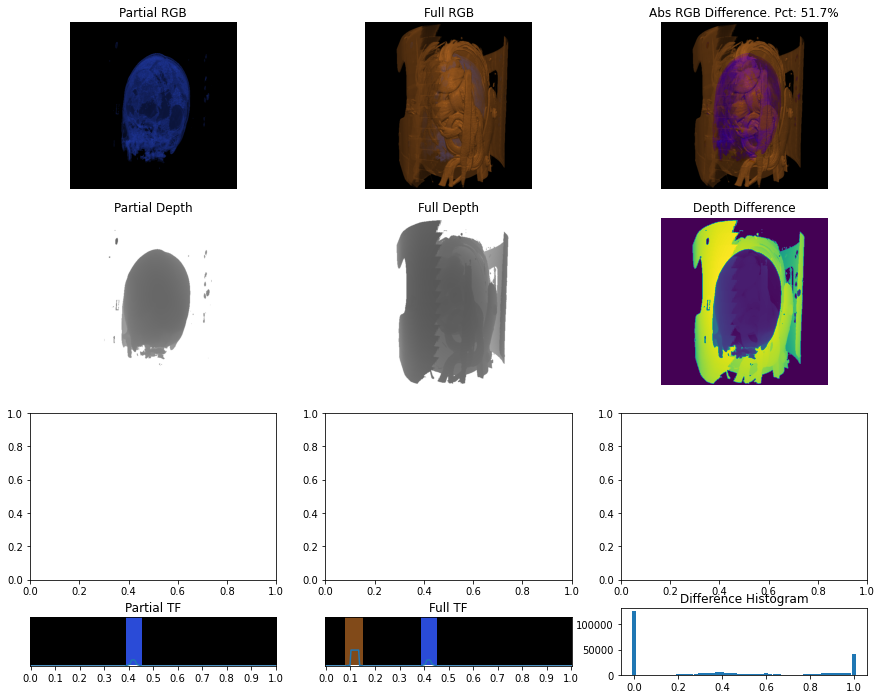

In [12]:
tf = tfgen.generate()
while len(tf) == 8: # single peak
    tf = tfgen.generate()
n_peaks = (len(tf)-2)//6
single_peaks = []
for i in range(n_peaks):
    peak = torch.cat([tf[[0]], tf[6*i+1 : 6*(i+1)+1], tf[[-1]]], dim=0)
    single_peaks.append({'pts': peak, 'tex': tex_from_pts(peak, TF_RES)})
    
rgbad_full = raycaster.raycast_nondiff(vol.float().cuda(), tex_from_pts(tf, TF_RES).float().cuda(),
                                       lf.float().cuda(), sampling_rate=SR).squeeze(0).detach().cpu()
rgbad_full[4:][(rgbad_full[4:] == 0.0)] = 1.0
show_im(rgbad_full)

single_peak_renders = []
for p in single_peaks:
    rgbad = raycaster.raycast_nondiff(vol.float().cuda(), p['tex'].float().cuda(), 
                                      lf.float().cuda(), sampling_rate=SR).squeeze(0)
    
    rgbad[4:][(rgbad[4:] == 0.0)] = 1.0
    
    single_peak_renders.append(rgbad.detach().cpu())
    fig, ax = plt.subplot_mosaic([['hist', 'hist', 'tf1'], 
                                  ['hist', 'hist', 'tf2'], 
                                  ['rgb', 'alpha', 'wysiwyp'],
                                  ['depth1', 'depth2', 'depth3'],
                                  ['alpha1', 'alpha2', 'alpha3'],
                                  ['sorted1', 'sorted2', 'sorted3']], figsize=(15,25), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
    })
    show_hist(rgbad[3], ax['hist'], title='Alpha Histogram')
    show_tf(p['pts'], ax=ax['tf1'], title='Current TF Peak')
    show_tf(tf, ax=ax['tf2'], title='Full Transfer Function')
    show_im(rgbad, axs=ax)
    
    fig.show()

for r, p in zip(single_peak_renders, single_peaks):
    abs_diff = torch.abs(r[:4] - rgbad_full[:4])
    abs_ddif = torch.abs(r[[4]] - rgbad_full[[4]])
    mae = abs_diff.mean()
    pct = (abs_diff.max(dim=0).values > 0.1).float().mean().item()
    fig, ax = plt.subplot_mosaic([['single', 'full', 'diff'],
                                  ['sdepth', 'fdepth', 'ddepth'],
                                  ['salpha', 'falpha', 'dalpha'],
                                  ['tf1', 'tf2', 'hist']], figsize=(15,12), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [5.0, 5.0, 5.0, 2.0]
    })
    ax['single'].imshow(r[:3].permute(1,2,0))
    ax['single'].set_title('Partial RGB')
    ax['single'].set_axis_off()
    
    ax['full'].imshow(rgbad_full[:3].permute(1,2,0))
    ax['full'].set_title('Full RGB')
    ax['full'].set_axis_off()
    ax['diff'].imshow(abs_diff[:3].permute(1,2,0))
    ax['diff'].set_title(f'Abs RGB Difference. Pct: {pct:.1%}')
    ax['diff'].set_axis_off()
    
    ax['sdepth'].imshow(r[[4,4,4]].permute(1,2,0))
    ax['sdepth'].set_title('Partial Depth')
    ax['sdepth'].set_axis_off()
    ax['fdepth'].imshow(rgbad_full[[4,4,4]].permute(1,2,0))
    ax['fdepth'].set_title('Full Depth')
    ax['fdepth'].set_axis_off()
    ax['ddepth'].imshow(abs_ddif.permute(1,2,0))
    ax['ddepth'].set_title('Depth Difference')
    ax['ddepth'].set_axis_off()
    show_tf(p['pts'], ax=ax['tf1'], title='Partial TF')
    show_tf(tf, ax=ax['tf2'], title='Full TF')
    show_hist(abs_diff.max(dim=0).values, ax['hist'], title='Difference Histogram', show_percentages=False)
    
    fig.show()
    

In [28]:
mask = rgbad_full[3] > 0.0
diff12 = (rgbad_full[5][mask] - rgbad_full[4][mask])
diff23 = (rgbad_full[6][mask] - rgbad_full[5][mask])
diff13 = (rgbad_full[6][mask] - rgbad_full[4][mask])

In [18]:
diff12.min(), diff12.mean(), diff12.max()

(tensor(-0.1369), tensor(0.0418), tensor(0.6592))

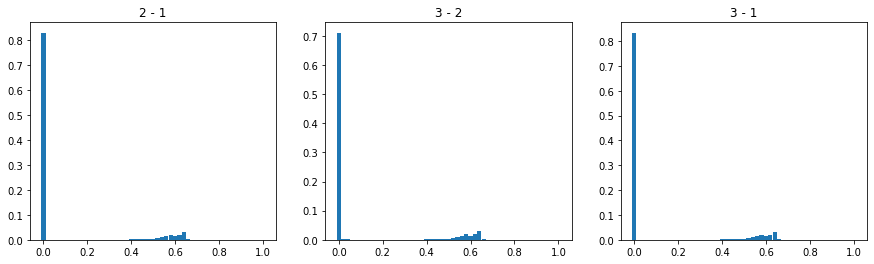

In [29]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
show_hist(diff12, ax=ax[0], title='2 - 1', show_percentages=False)
show_hist(diff23, ax=ax[1], title='3 - 2', show_percentages=False)
show_hist(diff13, ax=ax[2], title='3 - 1', show_percentages=False)

In [6]:
raycaster = None
skips = 0
visibilities = []
for v in trange(N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, mode=MODE,
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, ti_kwargs={'device_memory_fraction':0.5})
    for i in trange(N_ITEMS // N_VOLUMES):
        while True:
            lf = get_rand_pos(1).float().to('cuda')
            tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
            rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
            hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0)
            vis = hst[1:-1].sum()/rgbad[3].numel() # Visibility as in % of pixels with 0.02 < a < 0.9
            if (rgbad[3] > 0.0).float().mean() < 0.1 and (rgbad[4] > 0.0).float().mean() < 0.1:
                skips += 1
                print(f'Skipping another useless render ({skips})')
                continue
            elif vis < 0.2:
                skips += 1
                print(f'Skipping another too transparent render ({skips})')
                continue
            else:
                visibilities.append(vis.cpu().float())
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': rgbad[:4].cpu().half(),
                    'wysiwyp1': rgbad[[4]].cpu().half(),
                    'wysiwyp2': rgbad[[5]].cpu().half(),
                    'wysiwyp3': rgbad[[6]].cpu().half(),
                    'alpha1': rgbad[[7]].cpu().half(),
                    'alpha2': rgbad[[8]].cpu().half(),
                    'alpha3': rgbad[[9]].cpu().half(),
                    'visibility': vis.cpu().float()
                }, out_dir/f'{nam}_{i}.pt')
                break
print(f'Average visibility in the dataset: {torch.stack(visibilitieslities).mean():.1%}')

  0%|          | 0/395 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (1)
Skipping another too transparent render (2)
Skipping another too transparent render (3)


  0%|          | 0/395 [00:12<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/hdd/dome/STDepth_data_multi_mg/CQ500-CT-0_0.pt'

Percentage 0.02 < Alpha < 0.9:  17.7%
Percentage        Alpha > 0.98: 5.5%
Percentage visible (>=0.02):    23.2%


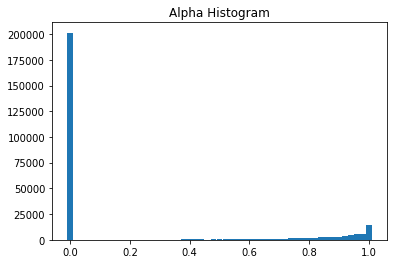

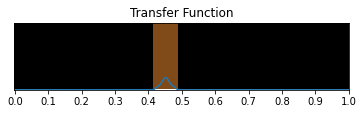

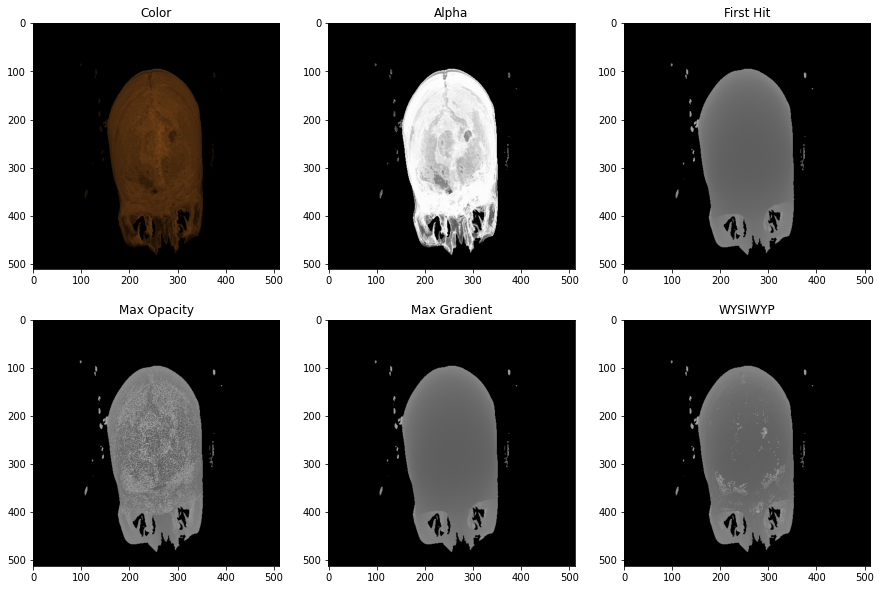

In [11]:
lf = in_circles(4.7)
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
x = torch.linspace(0.0, 1.0, BINS)
hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0).cpu()
print(f'Percentage 0.02 < Alpha < 0.9:  {hst[1:-1].sum()/rgbad[3].numel():.1%}')
print(f'Percentage        Alpha > 0.98: {hst[-1]/rgbad[3].numel():.1%}')
print(f'Percentage visible (>=0.02):    {1.0 - hst[0]/rgbad[3].numel():.1%}')
plt.bar(x, hst, width=1/BINS)
plt.title('Alpha Histogram')
plt.show()
plot_tf(tf, title='Transfer Function')
show_im(rgbad)